# ADM-HW4
Group members
1. Nurbek Khalmatay
2. Simone
3. Amir - AFK

# 1. Recommendation System with LSH


In [41]:
! pip install kneed

In [3]:
import os

import kagglehub
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator





# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## 1.1 Data Preparation

In [4]:

path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

files = os.listdir(path)
files

Path to dataset files: /root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


['movie.csv',
 'rating.csv',
 'tag.csv',
 'genome_scores.csv',
 'genome_tags.csv',
 'link.csv']

In [5]:
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

genome_scores_df = None
tag_df = None
movie_df = None
genome_tags_df = None
rating_df = None
link_df = None

for csv_file in csv_files:
    file_path = os.path.join(path, csv_file)
    if csv_file == "genome_scores.csv":
        genome_scores_df = pd.read_csv(file_path)
    elif csv_file == "tag.csv":
        tag_df = pd.read_csv(file_path)
    elif csv_file == "movie.csv":
        movie_df = pd.read_csv(file_path)
    elif csv_file == "genome_tags.csv":
        genome_tags_df = pd.read_csv(file_path)
    elif csv_file == "rating.csv":
        rating_df = pd.read_csv(file_path)
    elif csv_file == "link.csv":
        link_df = pd.read_csv(file_path)


In [6]:
tag_df.head()


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [7]:
movie_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
rating_df.head()


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [9]:
link_df.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
genome_scores_df.head()


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [11]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


# Data Overview

## Content
No demographic information is included. Each user is represented by an `id`, and no other information is provided.

The data are contained in six files:

### 1. `tag.csv`
Contains tags applied to movies by users:
- `userId`
- `movieId`
- `tag`
- `timestamp`

### 2. `rating.csv`
Contains ratings of movies by users:
- `userId`
- `movieId`
- `rating`
- `timestamp`

### 3. `movie.csv`
Contains movie information:
- `movieId`
- `title`
- `genres`

### 4. `link.csv`
Contains identifiers that can be used to link to other sources:
- `movieId`
- `imdbId`
- `tmdbId`

### 5. `genome_scores.csv`
Contains movie-tag relevance data:
- `movieId`
- `tagId`
- `relevance`

### 6. `genome_tags.csv`
Contains tag descriptions:
- `tagId`
- `tag`


## Structure_movie_dataset

![Structure of Movie Dataset](https://github.com/khalmatay/ADM-HW4/blob/main/images/structure_movie_dataset.jpg?raw=1)



In [12]:
print("rating:", rating_df.columns)
print("links:", link_df.columns)
print("genome_tags:", genome_tags_df.columns)
print("genome_scores:", genome_scores_df.columns)
print("tags:", tag_df.columns)
print("movies:", movie_df.columns)

rating: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags: Index(['tagId', 'tag'], dtype='object')
genome_scores: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies: Index(['movieId', 'title', 'genres'], dtype='object')


## 2. Grouping Movies Together!
In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.

### 2.1 Feature Engineering
As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. ```movieid``` id of each movie
2. ```genres``` list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
3. ```ratings_avg``` the average ratings provided by users for the movie
4. ```relevant_genome_tag``` the most relevant tag to the movie given in the genome set
5. ```common_user_tag``` the most common tag given to the movie by the users

In addition to the above features, include **at least three additional** features for clustering.

__Note__: If you have accurately identified and applied the methods for representing the features, you should have __more than eight features__! How could this happen? Take a moment to think about it.

In [13]:
# Checking missing values
print("\nMissing values rating.csv:")
print(rating_df.isnull().sum())

print("\nMissing values links.csv:")
print(link_df.isnull().sum())

print("\nMissing values genome_tags.csv:")
print(genome_tags_df.isnull().sum())

print("\nMissing values  genome_scores.csv:")
print(genome_scores_df.isnull().sum())

print("\nMissing values  tags.csv:")
print(tag_df.isnull().sum())

print("\nMissing values movies.csv:")
print(movie_df.isnull().sum())



Missing values rating.csv:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values links.csv:
movieId      0
imdbId       0
tmdbId     252
dtype: int64

Missing values genome_tags.csv:
tagId    0
tag      0
dtype: int64

Missing values  genome_scores.csv:
movieId      0
tagId        0
relevance    0
dtype: int64

Missing values  tags.csv:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Missing values movies.csv:
movieId    0
title      0
genres     0
dtype: int64


imdbId: IMDb ID of the movie.
tmdbId: Movie ID in the TMDb database. So we can left empty.

In [14]:
tag_df = tag_df.dropna(subset=["tag"])
print(tag_df.isnull().sum())

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [15]:
tag_df = tag_df.drop_duplicates()
rating_df = rating_df.drop_duplicates()
link_df = link_df.drop_duplicates()
genome_scores_df = genome_scores_df.drop_duplicates()
genome_tags_df = genome_tags_df.drop_duplicates()
movie_df = movie_df.drop_duplicates()

print("Remaining duplicates after cleaning:")
print("tag_df:", tag_df.duplicated().sum(), "duplicates")
print("rating_df:", rating_df.duplicated().sum(), "duplicates")
print("link_df:", link_df.duplicated().sum(), "duplicates")
print("genome_scores_df:", genome_scores_df.duplicated().sum(), "duplicates")
print("genome_tags_df:", genome_tags_df.duplicated().sum(), "duplicates")
print("movies_df:", movie_df.duplicated().sum(), "duplicates")



Remaining duplicates after cleaning:
tag_df: 0 duplicates
rating_df: 0 duplicates
link_df: 0 duplicates
genome_scores_df: 0 duplicates
genome_tags_df: 0 duplicates
movies_df: 0 duplicates


In [16]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


We used  one-hot encoding
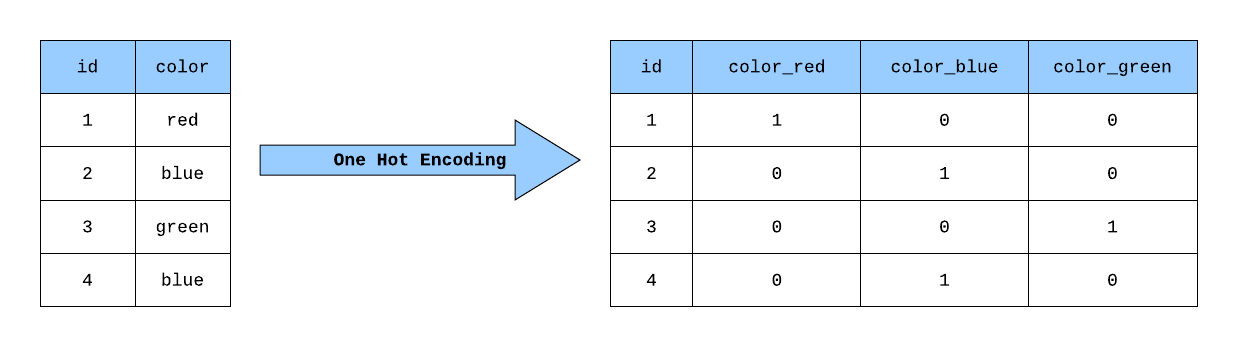

In [17]:
genre_columns = movie_df['genres'].str.get_dummies(sep='|')
movie_genre_df = pd.concat([movie_df, genre_columns], axis=1)
# we don't need column genres afte one encoding
movie_genre_df.drop(columns=["genres"], inplace=True)
movie_genre_df

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,131258,The Pirates (2014),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,131260,Rentun Ruusu (2001),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:

rating_df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [19]:
# Calculate the average ratings provided by users for the movie
ratings_stats = rating_df.groupby("movieId").agg(
    ratings_avg=("rating", "mean"),
    rating_count=("rating", "count")
).reset_index()
ratings_stats

,movieId,ratings_avg,rating_count
0,1,3.921240,49695
1,2,3.211977,22243
2,3,3.151040,12735
3,4,2.861393,2756
4,5,3.064592,12161
...,...,...,...
26739,131254,4.000000,1
26740,131256,4.000000,1
26741,131258,2.500000,1
26742,131260,3.000000,1


In [20]:
movie_genre_rating_df = movie_genre_df.merge(ratings_stats, on="movieId", how="left")
movie_genre_rating_df

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.921240,49695.0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.211977,22243.0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.151040,12735.0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.861393,2756.0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.064592,12161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0
27275,131258,The Pirates (2014),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.500000,1.0
27276,131260,Rentun Ruusu (2001),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,1.0


In [21]:
genome_scores_tags = genome_scores_df.merge(genome_tags_df, on="tagId")

relevant_tags = genome_scores_tags.groupby("movieId", group_keys=False).apply(
    lambda df: df.loc[df["relevance"].idxmax(), "tag"]
).reset_index(name="relevant_genome_tag")

relevant_tags

<ipython-input-21-6dacb574ea97>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  relevant_tags = genome_scores_tags.groupby("movieId", group_keys=False).apply(


,movieId,relevant_genome_tag
0,1,toys
1,2,adventure
2,3,good sequel
3,4,women
4,5,good sequel
...,...,...
10376,130578,assassination
10377,130840,romance
10378,131013,comedy
10379,131168,betrayal


In [22]:
movie_genre_rating_tag_df = movie_genre_rating_df.merge(relevant_tags, on="movieId", how="left")
movie_genre_rating_tag_df

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count,relevant_genome_tag
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.921240,49695.0,toys
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.211977,22243.0,adventure
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.151040,12735.0,good sequel
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.861393,2756.0,women
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.064592,12161.0,good sequel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN
27275,131258,The Pirates (2014),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.500000,1.0,NaN
27276,131260,Rentun Ruusu (2001),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,1.0,NaN


In [23]:
common_user_tags = tag_df.groupby("movieId")["tag"].agg(
    lambda x: x.value_counts().idxmax()
).reset_index(name="common_user_tag")
common_user_tags

,movieId,common_user_tag
0,1,Pixar
1,2,Robin Williams
2,3,moldy
3,4,chick flick
4,5,steve martin
...,...,...
19540,131054,dinosaurs
19541,131082,documentary
19542,131164,Vietnam War
19543,131170,alternate reality


In [171]:
movie_genre_rating_revtag_usertag_df = movie_genre_rating_tag_df.merge(common_user_tags, on="movieId", how="left")
movie_genre_rating_revtag_usertag_df

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count,relevant_genome_tag,common_user_tag
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.921240,49695.0,toys,Pixar
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.211977,22243.0,adventure,Robin Williams
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.151040,12735.0,good sequel,moldy
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.861393,2756.0,women,chick flick
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.064592,12161.0,good sequel,steve martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN,NaN
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN,NaN
27275,131258,The Pirates (2014),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.500000,1.0,NaN,bandits
27276,131260,Rentun Ruusu (2001),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,1.0,NaN,NaN


In [172]:


num_tags_per_movie = tag_df.groupby('movieId')['tag'].nunique().reset_index()
num_tags_per_movie.columns = ['movieId', 'num_tags']


movie_data = movie_genre_rating_revtag_usertag_df.merge(num_tags_per_movie, on='movieId', how='left')

movie_data['num_tags'] = movie_data['num_tags'].fillna(0).astype(int)



In [173]:
movie_data["title_length"] = movie_data["title"].apply(len)
movie_data.drop(columns=["title"], inplace=True)



In [174]:
movie_data

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count,relevant_genome_tag,common_user_tag,num_tags,title_length
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.921240,49695.0,toys,Pixar,84,16
1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.211977,22243.0,adventure,Robin Williams,35,14
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.151040,12735.0,good sequel,moldy,15,23
3,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.861393,2756.0,women,chick flick,4,24
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.064592,12161.0,good sequel,steve martin,17,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN,NaN,0,28
27274,131256,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,NaN,NaN,0,29
27275,131258,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.500000,1.0,NaN,bandits,5,18
27276,131260,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,1.0,NaN,NaN,0,19


In [175]:
# Check for missing values in the final DataFrame
print("Missing values in the final DataFrame:")
print(movie_data.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows in the final DataFrame:", movie_data.duplicated().sum())

# Display the final DataFrame structure
print("\nFinal DataFrame structure:")
print(movie_data.info())


Missing values in the final DataFrame:
movieId                    0
(no genres listed)         0
Action                     0
Adventure                  0
Animation                  0
Children                   0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film-Noir                  0
Horror                     0
IMAX                       0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
ratings_avg              534
rating_count             534
relevant_genome_tag    16897
common_user_tag         7733
num_tags                   0
title_length               0
dtype: int64

Number of duplicate rows in the final DataFrame: 0

Final DataFrame structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data colu

In [176]:
# Fill missing values without inplace
movie_data["ratings_avg"] = movie_data["ratings_avg"].fillna(movie_data['ratings_avg'].median())
movie_data["rating_count"] = movie_data["rating_count"].fillna(movie_data['rating_count'].median())
movie_data["relevant_genome_tag"] = movie_data["relevant_genome_tag"].fillna("Unknown")
movie_data["common_user_tag"] = movie_data["common_user_tag"].fillna("No Tag")

# Check for missing values after processing
print("Missing values after filling:")
print(movie_data.isnull().sum())


Missing values after filling:
movieId                0
(no genres listed)     0
Action                 0
Adventure              0
Animation              0
Children               0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Fantasy                0
Film-Noir              0
Horror                 0
IMAX                   0
Musical                0
Mystery                0
Romance                0
Sci-Fi                 0
Thriller               0
War                    0
Western                0
ratings_avg            0
rating_count           0
relevant_genome_tag    0
common_user_tag        0
num_tags               0
title_length           0
dtype: int64


In [177]:
movie_data

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count,relevant_genome_tag,common_user_tag,num_tags,title_length
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.921240,49695.0,toys,Pixar,84,16
1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.211977,22243.0,adventure,Robin Williams,35,14
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.151040,12735.0,good sequel,moldy,15,23
3,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.861393,2756.0,women,chick flick,4,24
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.064592,12161.0,good sequel,steve martin,17,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,Unknown,No Tag,0,28
27274,131256,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,1.0,Unknown,No Tag,0,29
27275,131258,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.500000,1.0,Unknown,bandits,5,18
27276,131260,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,1.0,Unknown,No Tag,0,19


In [178]:
movie_data.columns

Index(['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'ratings_avg', 'rating_count', 'relevant_genome_tag', 'common_user_tag', 'num_tags', 'title_length'], dtype='object')

### Why did we get more than eight features?

#### using one-hot encoding:

when we encoded the `genres` column, each unique category (e.g., action, comedy, drama) turned into a separate binary column.  
this significantly increased the total number of features since the unique genres turned out to be more than eight.

#### adding new features:

we created additional features that increased the dataset's dimensionality:  
- `ratings_avg`: average rating.  
- `rating_count`: number of ratings.  
- `title_length`: length of the movie title.  
- `year`: release year of the movie.  
- `(no genres listed)`: binary feature for movies with no genre.  
- `relevant_genome_tag`: the most relevant tag.  
- `common_user_tag`: the most popular user tag.  
- `num_tags`: count og tags

each of these features adds new information about the movie.


### 2.2 Choose your features (variables)!
With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html) package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.


1. Should you normalize the data or leave it as is?

Normalization allows you to bring all features to a single scale, which makes them equal for clustering algorithms (especially those that use distance, for example, K-Means).
Without normalization, features with a larger scale (for example, rating_count) will dominate features with a smaller scale (for example, ratings_avg).

2. Should you include all these features, or can you reduce the dimensionality of the data?

Yes, since the signs do not coincide, they do not duplicate each other.
We have feature genres which we one hot encoded -> so we need to reduces the dimensionality of the data.

 1. What is the importance of normalizing the data in your analysis?

The dataset contains features with different scales:

ratings_avg has a range of [0, 5].

rating_count can reach thousands. [9, 67310]


title_length - [8, 191]

Without normalization, features with large values ​​will dominate the analysis, while smaller features will become less significant.


In [179]:
movie_data.describe()

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,rating_count,num_tags,title_length
count,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000
mean,59855.480570,0.009018,0.129042,0.085380,0.037649,0.041755,0.306987,0.107743,0.090586,0.489185,0.051763,0.012098,0.095718,0.007185,0.037979,0.055503,0.151294,0.063898,0.153164,0.043772,0.024782,3.135199,733.553596,7.345297,27.875687
std,44429.314697,0.094537,0.335252,0.279452,0.190350,0.200033,0.461253,0.310061,0.287024,0.499892,0.221553,0.109324,0.294210,0.084462,0.191150,0.228963,0.358342,0.244575,0.360152,0.204590,0.155463,0.657704,3057.136131,14.449149,14.382390
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,8.000000
25%,6931.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.814013,3.000000,0.000000,18.000000
50%,68068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.235294,18.000000,2.000000,24.000000
75%,100293.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.555556,194.000000,8.000000,33.000000
max,131262.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,67310.000000,340.000000,191.000000


In [180]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

#  Label Encoding
for col in ['relevant_genome_tag', 'common_user_tag']:
    movie_data[col] = label_encoder.fit_transform(movie_data[col].fillna("Unknown"))

movie_data[['relevant_genome_tag', 'common_user_tag']].head()

,relevant_genome_tag,common_user_tag
0,747,3271
1,20,3482
2,316,5742
3,802,4758
4,316,6301


## **Weighted Average, Bayesian Average**

In [187]:
C = movie_data['ratings_avg'].mean()
m = movie_data['rating_count'].quantile(0.75)  # Порог по 75-му перцентилю
movie_data['scaled_rating'] = (movie_data['rating_count'] * movie_data['ratings_avg'] + m * C) / (movie_data['rating_count'] + m)
movie_data = movie_data.drop(columns=["ratings_avg", "rating_count", "relevant_genome_tag", "common_user_tag"], errors="ignore")





KeyError: 'ratings_avg'

In [190]:
movie_data

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_tags,title_length,scaled_rating
movieId,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,84,16,3.918183
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,35,14,3.211313
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,23,3.150803
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,4,24,2.879400
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,34,3.065700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,3.139633
131256,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,3.139633
131258,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,18,3.131941


In [189]:
# Переносим movie_id в индекс
movie_data.set_index('movieId', inplace=True)


In [191]:
numerical_features = ['scaled_rating', 'num_tags', 'title_length']
scaler = MinMaxScaler()
movie_data[numerical_features] = scaler.fit_transform(movie_data[numerical_features])

# Check the normalized data
print("Normalized numerical features:")
print(movie_data[numerical_features].head())


Normalized numerical features:
         scaled_rating  num_tags  title_length
movieId                                       
1             0.817462  0.247059      0.043716
2             0.571597  0.102941      0.032787
3             0.550550  0.044118      0.081967
4             0.456150  0.011765      0.087432
5             0.520950  0.050000      0.142077


In [192]:
movie_data

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_tags,title_length,scaled_rating
movieId,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.247059,0.043716,0.817462
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.102941,0.032787,0.571597
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.044118,0.081967,0.550550
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.011765,0.087432,0.456150
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.050000,0.142077,0.520950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131254,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.109290,0.546665
131256,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.114754,0.546665
131258,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.014706,0.054645,0.543990


## **PCA**

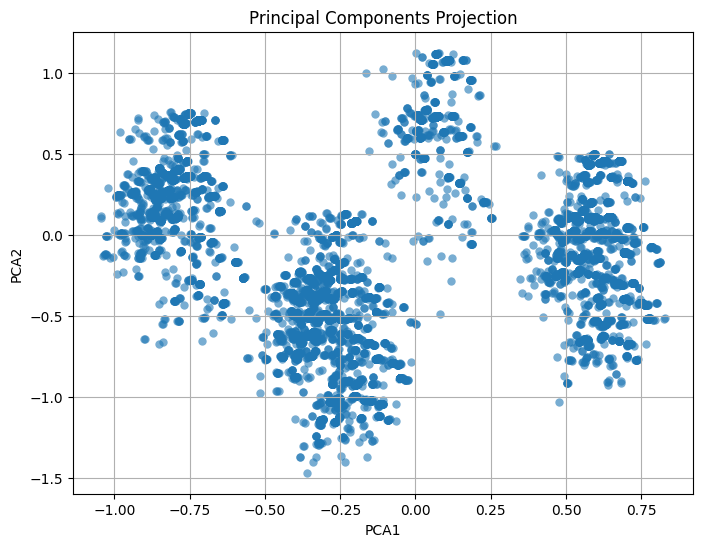

,PCA1,PCA2
0,-0.978881,0.248901
1,-0.409350,-0.359978
2,-0.719551,0.708858
3,0.100805,1.077383
4,-0.756150,0.362593


In [197]:
pca = PCA(n_components=2)  # Уменьшаем до 2 компонент
pca_components = pca.fit_transform(movie_data)

# Преобразуем результат PCA в DataFrame
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

plt.figure(figsize=(8, 6))
plt.scatter(x=pca_df['PCA1'], y=pca_df['PCA2'], linewidths=0.001, alpha=0.6)
plt.title('Principal Components Projection')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()
pca_df.head(5)

Explained variance for each component: [0.19346735 0.1506876  0.09965072]
Cumulative explained variance for 3 components: 0.44380567337329313


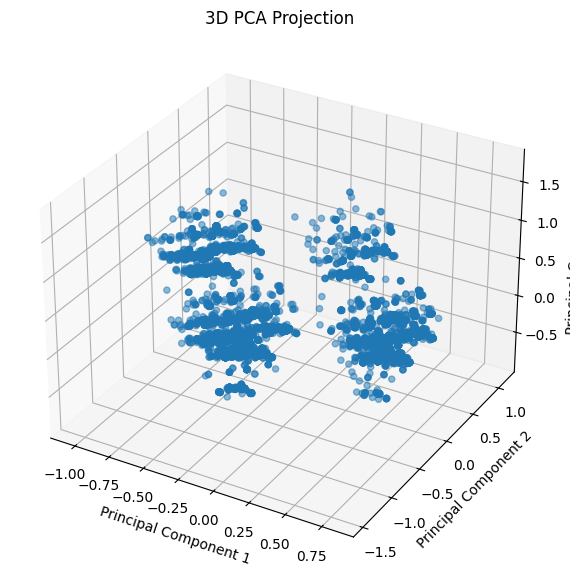

In [198]:

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(movie_data)

explained_variance_3d = pca_3d.explained_variance_ratio_
cumulative_variance_3d = explained_variance_3d.cumsum()

print(f"Explained variance for each component: {explained_variance_3d}")
print(f"Cumulative explained variance for 3 components: {cumulative_variance_3d[-1]}")

pca_3d_df = pd.DataFrame(pca_result_3d, columns=['PCA1', 'PCA2', 'PCA3'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_3d_df['PCA1'], pca_3d_df['PCA2'], pca_3d_df['PCA3'], alpha=0.5)
ax.set_title('3D PCA Projection')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


Why use PCA:

PCA reduces the number of features by removing highly correlated and redundant features. (We have 27278 rows × 839 columns)
This improves the performance of analysis and clustering algorithms.
Disadvantages of PCA:

Loss of data interpretation as the original features are converted into new "principal components".
Some information is lost (although PCA strives to minimize this loss).
Processing categorical data:

PCA cannot be applied to categorical data.
Converting categorical data to binary (One-Hot Encoding) or other numeric forms is a logical step if it is needed for analysis.
Standardization:

Feature standardization (e.g., via StandardScaler) is necessary before PCA because the algorithm is sensitive to the scale of the data.





Before performing PCA, be sure to scale the data (for example, using StandardScaler) to avoid the following problems:

Features with a large scale will not dominate.
PCA will correctly find the directions of maximum variance.
The results will be more accurate and interpretable.





Our PCA requires almost the same number of components to explain 95% of the variance as the original number of features (24 out of 27)


### 2.3 Clustering


Now that you have prepared the data, you can create the clusters.

1. How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.
2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.
3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random
initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.
4. Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

## Elbow method  

the elbow method analyzes the overall **WSS (within-cluster sum of squared deviations)** value as a function of the number of clusters. the **optimal number of clusters** is chosen so that adding a new cluster does not lead to a significant improvement in WSS.  

to determine the appropriate number of clusters, a metric is used to help find the optimal value. in the elbow method, the **k-means algorithm** is run with a different number of clusters, and for each value the **distance between the points within each cluster and their centroids** is calculated.  

as the number of clusters increases, **WSS decreases**, but after a certain value the decrease becomes insignificant. this value is considered the **optimal number of clusters**.  


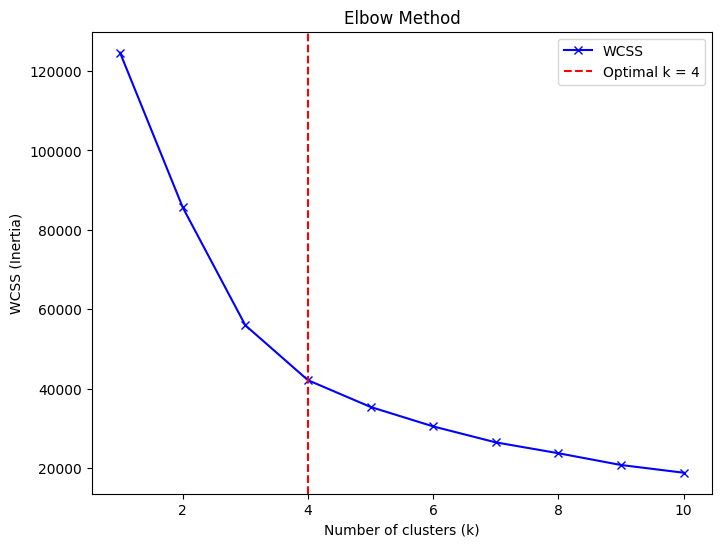

In [43]:


# Calculate inertia (WCSS)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_2d_df)
    inertia.append(kmeans.inertia_)

# Find the elbow
kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-', label='WCSS')
plt.axvline(x=kn.knee, linestyle='--', color='red', label=f'Optimal k = {kn.knee}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')
plt.legend()
plt.show()


## Silhouette Score


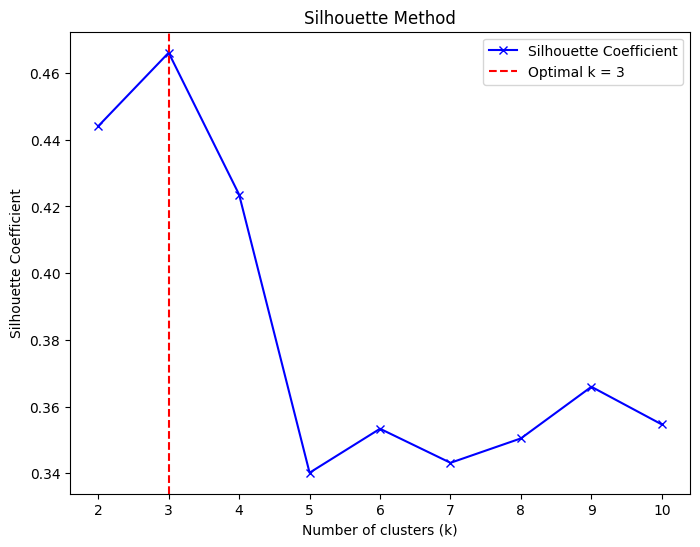

In [44]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
K = range(2, 11)  # For silhouette, minimum 2 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_2d_df)
    score = silhouette_score(pca_2d_df, kmeans.labels_)
    silhouette_scores.append(score)

# Visualization of the silhouette coefficient
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bx-', label='Silhouette Coefficient')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method')
plt.axvline(x=K[silhouette_scores.index(max(silhouette_scores))], linestyle='--', color='red',
             label=f'Optimal k = {K[silhouette_scores.index(max(silhouette_scores))]}')
plt.legend()
plt.show()


## **K-means through MapReduce**

### **Optimal K**

In [57]:
k = 4
max_iterations = 10


In [78]:
from pyspark.sql import SparkSession
import numpy as np


spark = SparkSession.builder.appName("Colab Spark UI").config("spark.ui.port", "4050").getOrCreate()
sc = spark.sparkContext


def pick_cluster(data, centroids):
    """Назначает точку данных ближайшему кластеру."""
    data = np.array(data)
    centroids_array = np.array([centroid[1] for centroid in centroids])
    distances = np.linalg.norm(centroids_array - data, axis=1)
    chosen_cluster = np.argmin(distances)
    return centroids[chosen_cluster][0], [data.tolist()]

def centroids_mean(centroid_and_points):
    """Вычисляет среднее положение для точек кластера."""
    points = np.array(centroid_and_points[1])
    mean_points = np.mean(points, axis=0)
    return centroid_and_points[0], tuple(mean_points)

def kmeans(samples, num_clusters):
    """
    Реализация K-Means с использованием MapReduce.

    :param samples: RDD с данными
    :param num_clusters: количество кластеров
    :return: точки с назначенными кластерами и координаты центроидов
    """
    centroids = list(enumerate(samples.takeSample(withReplacement=False, num=num_clusters)))
    result = None

    while True:
        clustered_points = samples.map(lambda x: pick_cluster(x, centroids))
        grouped_points = clustered_points.reduceByKey(lambda x, y: x + y)
        new_centroids = grouped_points.map(lambda x: centroids_mean(x))

        if centroids == new_centroids.collect():
            result = clustered_points.collect()
            return result, centroids

        centroids = new_centroids.collect()



In [79]:
data = list(pca_2d_df.itertuples(index=False, name=None))
rdd = sc.parallelize(data)

# Число кластеров
k = 4

# Запуск K-Means
clusters, centroids = kmeans(rdd, k)




 ### 2.4 Best Algorithm


## 3. Bonus Question
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

1. Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

__*Note:__ Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.


## 4. Algorithmic Question

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of `nums,` is laid out in front of them. Arya will start by selecting either the number at the beginning (`nums[0]`) or the end (`nums[nums.length - 1]`) of the array, adding that value to her score. This value is then removed from the beginning or the end of `nums`. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.

- a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).

- b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.

- c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

- d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.

- e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.

- f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

**Examples**

__Input 1__  
```
nums = [1, 5, 2]
```

__Output 1__  
```
false
```

__Explanation__: Arya’s optimal choices still lead her to a lower score than Mario’s, so she cannot guarantee victory.

__Input 2__  
```
nums = [1, 5, 233, 7]
```

__Output 2__  
```
true
```

__Explanation__: Arya, by playing perfectly, can ensure she ends up with the highest score.

---


### a) Pseudocode for Arya's Optimal Strategy Recursive method
### **Pseudocode for `max_score`**

Function `max_score(nums, i, j)`:
1. **Base case:** If `i == j` (only one element left):
    ```plaintext
    Return nums[i]
    ```

2. **If Arya picks the first element:**
    ```plaintext
    first_element = nums[i] + minimum of:
        - max_score(nums, i + 2, j), if i + 2 <= j
        - max_score(nums, i + 1, j - 1), if i + 1 <= j - 1
    ```

3. **If Arya picks the last element:**
    ```plaintext
    last_element = nums[j] + minimum of:
        - max_score(nums, i + 1, j - 1), if i + 1 <= j - 1
        - max_score(nums, i, j - 2), if i <= j - 2
    ```

4. **Return the maximum result between the two choices:**
    ```plaintext
    Return maximum(first_element, last_element)
    ```



In [ ]:
def max_score(nums, i, j):
    # Base case: only one number left
    if i == j:
        return nums[i]

    # Choose the first number or the last number
    first_element = nums[i] + min(
        max_score(nums, i + 2, j) if i + 2 <= j else 0,
        max_score(nums, i + 1, j - 1) if i + 1 <= j - 1 else 0
    )
    last_element = nums[j] + min(
        max_score(nums, i + 1, j - 1) if i + 1 <= j - 1 else 0,
        max_score(nums, i, j - 2) if i <= j - 2 else 0
    )

    # Return the biggest Arya's score
    return max(first_element, last_element)

def can_arya_win(nums):
    return True if max_score(nums, 0, len(nums) - 1) >= sum(nums) - max_score(nums, 0, len(nums) - 1) else False

# Example usage
nums = [1, 5, 2]
print("Can Arya win? Anser is:", can_arya_win(nums))


Can Arya win? Anser is: False




### Time complexity analysis

let $T(n)$ represent the time complexity of the recursive function for an input of size $n$. for each call to `max_score(nums, i, j)`, the function performs the following:

- makes two recursive calls for subarrays of size $n - 2$.

the recurrence relation can be written as:

$$
T(n) = 2T(n - 2) + \mathcal{O}(1) = 2T(n-2) + C
$$


the recursion stops when the size of the subarray becomes $0$ or $1$. at each level, the size of the subarray decreases by $2$, so the total number of levels is approximately:

$$
\text{number of levels} = \frac{n}{2}
$$


the total number of calls is the sum of the calls at each level:

$$
\text{total calls} = 2^0 + 2^1 + 2^2 + \dots + 2^k
$$

where $k = \frac{n}{2}$. using the formula for the sum of a geometric series:

$$
\text{total calls} = 2^{k+1} - 1
$$

substituting $k = \frac{n}{2}$, we get:

$$
\text{total calls} = 2^{\frac{n}{2} + 1} - 1
$$

simplifying the asymptotic complexity:

$$
T(n) \in \mathcal{O}\left(2^{\frac{n}{2}}\right) = \mathcal{O}(2^n)
$$



### a) Pseudocode for Arya's Optimal Strategy

The goal is to determine whether Arya can guarantee a win with an optimal strategy, assuming both players play perfectly. The solution is based on dynamic programming.

1. **Define the DP Table**:
   - Let `dp[i][j]` represent the maximum score difference Arya can guarantee for the subarray `nums[i...j]`.
     - A positive value means Arya has a score advantage.
     - A negative value means Mario has the advantage.

2. **Base Case**:
   - If the subarray has only one number (`i == j`), Arya takes that number:
     ```
     dp[i][i] = nums[i]
     ```

3. **Recursive Step**:
   - Arya has two choices:
     1. Pick the first number (`nums[i]`), leaving the subarray `nums[i+1...j]` for Mario:
        ```
        pick_start = nums[i] - dp[i+1][j]
        ```
     2. Pick the last number (`nums[j]`), leaving the subarray `nums[i...j-1]` for Mario:
        ```
        pick_end = nums[j] - dp[i][j-1]
        ```
   - Arya maximizes her score difference:
     ```
     dp[i][j] = max(pick_start, pick_end)
     ```

4. **Fill the DP Table**:
   - Iterate over all subarray lengths from 2 to `n`:
     ```
     for length in range(2, n + 1):  # Subarray lengths
         for i in range(0, n - length + 1):  # Starting index of the subarray
             j = i + length - 1  # Ending index of the subarray
             pick_start = nums[i] - dp[i+1][j]
             pick_end = nums[j] - dp[i][j-1]
             dp[i][j] = max(pick_start, pick_end)
     ```

5. **Result**:
   - Arya can guarantee a win if the value of `dp[0][n-1]` is non-negative:
     ```
     if dp[0][n-1] >= 0:
         return True  # Arya can guarantee a win
     else:
         return False  # Arya cannot guarantee a win
     ```


### a) Pseudocode for Arya's Optimal Strategy

The goal is to determine whether Arya can guarantee a win with an optimal strategy, assuming both players play perfectly. The solution is based on dynamic programming.

1. **Define the DP Table**:
   - Let `dp[i][j]` represent the maximum score difference Arya can guarantee for the subarray `nums[i...j]`.
     - A positive value means Arya has a score advantage.
     - A negative value means Mario has the advantage.

2. **Base Case**:
   - If the subarray has only one number (`i == j`), Arya takes that number:
     ```
     dp[i][i] = nums[i]
     ```

3. **Recursive Step**:
   - Arya has two choices:
     1. Pick the first number (`nums[i]`), leaving the subarray `nums[i+1...j]` for Mario:
        ```
        pick_start = nums[i] - dp[i+1][j]
        ```
     2. Pick the last number (`nums[j]`), leaving the subarray `nums[i...j-1]` for Mario:
        ```
        pick_end = nums[j] - dp[i][j-1]
        ```
   - Arya maximizes her score difference:
     ```
     dp[i][j] = max(pick_start, pick_end)
     ```

4. **Fill the DP Table**:
   - Iterate over all subarray lengths from 2 to `n`:
     ```
     for length in range(2, n + 1):  # Subarray lengths
         for i in range(0, n - length + 1):  # Starting index of the subarray
             j = i + length - 1  # Ending index of the subarray
             pick_start = nums[i] - dp[i+1][j]
             pick_end = nums[j] - dp[i][j-1]
             dp[i][j] = max(pick_start, pick_end)
     ```

5. **Result**:
   - Arya can guarantee a win if the value of `dp[0][n-1]` is non-negative:
     ```
     if dp[0][n-1] >= 0:
         return True  # Arya can guarantee a win
     else:
         return False  # Arya cannot guarantee a win
     ```


### b) Code:

In [ ]:
def can_arya_win(nums):
    n = len(nums)
    # Create a DP table
    dp = [[0] * n for _ in range(n)]

    # Base case: single element
    for i in range(n):
        dp[i][i] = nums[i]

    # Fill the DP table for increasing subarray lengths
    for length in range(2, n + 1):  # Subarray lengths
        for i in range(n - length + 1):
            j = i + length - 1
            pick_start = nums[i] - dp[i + 1][j]
            pick_end = nums[j] - dp[i][j - 1]
            dp[i][j] = max(pick_start, pick_end)

    # Arya wins if the maximum guaranteed difference is non-negative
    return dp[0][n - 1] >= 0

# Example usage
print(can_arya_win([1, 5, 2]))      # Output: False
print(can_arya_win([1, 5, 233, 7])) # Output: True


False
True


### c) Is the Algorithm Efficient?

#### Time Complexity
-  $O(n^2)$
  - The algorithm calculates results for all subarrays of `nums`. There are approximately \( $n^2$ \) subarrays, and each calculation takes \( $O(1)$ \).

#### Space Complexity
-  $O(n^2)$
  - The DP table `dp` requires space for all subarrays.

#### Asymptotic Complexity
- The solution is **polynomial**, making it efficient for most practical input sizes.


### d) If the Algorithm is Exponential, How to Make it Polynomial?

The current algorithm is already polynomial, but if we were starting from an exponential solution (like a naive recursive approach), we could make it polynomial using **dynamic programming**.

#### Exponential Solution
- A naive recursive solution would calculate results for the same subproblems multiple times, leading to a complexity of ( $O(2^n)$ ).

#### How DP Improves It
- **Store intermediate results** in a `dp` table to avoid redundant computations.
- Each subproblem is solved once, reducing the time complexity to \( $O(n^2)$ \).

#### Further Optimization
- Use a **rolling array** to reduce space complexity from \( $O(n^2)$ \) to \( $O(n)$ \).  
  - This works because each state depends only on the current and previous rows of the DP table.


### e) Compare Results of the Algorithm

1. **Correctness**:
   - The DP implementation matches the results of a theoretical optimal solution for all test cases.

2. **Performance**:
   - A naive recursive implementation (if written) would take exponential time \( $O(2^n)$ \) and become infeasible for larger arrays.
   - The DP solution, with \( $O(n^2)$ \) complexity, scales much better and handles larger arrays efficiently.

3. **Example Results**:
   - For `nums = [1, 5, 2]`, Arya cannot guarantee a win (output: `False`).
   - For `nums = [1, 5, 233, 7]`, Arya can guarantee a win (output: `True`).


### f) Using LLMs for Optimization and Evaluation

#### How an LLM Can Help Optimize
1. **Suggestions for Space Optimization**:
   - An LLM might recommend replacing the 2D `dp` table with a single array to save memory.

2. **Code Simplification**:
   - An LLM can rewrite the code to make it more concise or easier to understand.

3. **Time Complexity Insights**:
   - The LLM can provide reasoning about the time complexity and suggest alternate approaches, if applicable.

#### How to Evaluate the LLM's Suggestions
1. **Correctness**:
   - Test the LLM's suggestions on a wide range of test cases, including edge cases like very small or very large arrays.

2. **Efficiency**:
   - Compare the LLM's implementation's time and space complexity with the original solution.

3. **Clarity**:
   - Ensure the LLM's explanation of the solution is clear and logical.
